In [6]:
import pandas as pd
import numpy as np
import librosa
import cv2
import os
import glob
import seaborn as sns
from tqdm import tqdm
import IPython.display
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
import warnings
warnings.simplefilter("ignore")

import cosine_similarity as cs
import freq_dataset as fd
cos = cs.CosineSimilarity()
freq = fd.MakeFreqDataset()

s_path = "../../sounds/"

In [7]:
# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정 변경
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

In [8]:
o_path = list(set(glob.glob(f'{s_path}*/*/*')))
path_ls = [file[3:] for file in o_path if file.endswith(".mp3") or file.endswith(".wav")]
name_ls = [name.split('/')[-1][:-4] for name in path_ls]
label_ls = [name.split('/')[-3] for name in path_ls]
info_df = pd.DataFrame()
info_df['path'] = path_ls
info_df['label'] = label_ls
info_df['name'] = name_ls
info_df

,path,label,name
0,../sounds/human_voice/read_women/4_4078.wav,human_voice,4_4078
1,../sounds/human_voice/read_women/1_0967.wav,human_voice,1_0967
2,../sounds/human_voice/read_women/sub100120a002...,human_voice,sub100120a00204
3,../sounds/human/crying/ODB7_11_2_0_28_0_0_0.wav,human,ODB7_11_2_0_28_0_0_0
4,../sounds/nature/비 소리/2-81731-A-10.wav,nature,2-81731-A-10
...,...,...,...
22480,../sounds/human/teeth-chattering/4O6R_0_3_0_24...,human,4O6R_0_3_0_24_0_0_0
22481,../sounds/human_voice/read_women/4_1610.wav,human_voice,4_1610
22482,../sounds/human_voice/read_women/3_0949.wav,human_voice,3_0949
22483,../sounds/human_voice/read_women/4_3766.wav,human_voice,4_3766


In [11]:
o_df = pd.read_csv("../files/freq_dataset_1113.csv", encoding='utf-8-sig')
o_df.drop(["Unnamed: 0", "label"], axis=1, inplace=True)
o_df['cate1'] = [p.split('/')[-3] for p in o_df['path']]
o_df['cate2'] = [p.split('/')[-1][:3] if p.split('/')[-2] == 'cats_dogs' else p.split('/')[-2] for p in o_df['path']]
o_df.drop(o_df[o_df['cate2']=='cats_dog_add_noise'].index, axis=0, inplace=True)
o_df['cate2'] = [c.replace("cat", "고양이") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("dog", "개") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("까마귀", "새") for c in o_df['cate2']]
o_df['cate2'] = [c.replace(" ", "") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("소리", "") for c in o_df['cate2']]
o_df.drop(o_df[o_df['name']=='2-76868-A-6'].index, axis=0, inplace=True) # 닭 test 음원
o_df.drop(o_df[o_df['name']=='2-95035-A-1'].index, axis=0, inplace=True) # 닭 test 음원
o_df = o_df[o_df['cate1'] == 'animal'].copy()
o_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
1,dr0shorse,../../sounds/animal/말 소리/dr0shorse.wav,1.353651,0.374280,0.095735,0.181595,0.006819,1492.603731,8.567513e+04,955.614463,...,12.378535,56.651711,-10.243791,28.035650,-3.035161,78.115898,1.781476,150.969696,animal,말
8,5-197446-A-7,../../sounds/animal/벌 소리/5-197446-A-7.wav,5.000000,0.459533,0.076533,0.055097,0.002021,2269.844202,1.710596e+05,2555.378258,...,-7.631099,15.183190,-3.202921,17.505238,-8.461825,13.419047,-3.178414,17.566444,animal,벌
38,dog_barking_108,../../sounds/animal/개 소리/dog_barking_108.wav,10.396689,0.659107,0.044288,0.041320,0.001408,3438.614128,9.251955e+05,2171.148015,...,11.429811,33.483120,-13.745112,28.966200,6.268610,26.215820,-7.755744,17.861032,animal,개
39,dog_barking_75,../../sounds/animal/cats_dogs/dog_barking_75.wav,2.593197,0.214954,0.096244,0.114834,0.006668,1103.800057,4.565354e+04,933.097892,...,-9.614342,409.729980,-9.015744,183.782593,0.607754,107.774826,1.981836,255.811737,animal,개
61,bird018,../../sounds/animal/새 소리/bird018.wav,3.007302,0.571848,0.057562,0.010360,0.000108,2694.216571,2.308462e+05,2418.067058,...,-8.622164,23.268013,-0.992545,24.511826,-5.178211,30.655552,-1.723059,18.721495,animal,새
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22397,dog_barking_84,../../sounds/animal/cats_dogs/dog_barking_84.wav,2.332336,0.228779,0.104588,0.075584,0.004076,1115.638823,2.511080e+04,922.167618,...,-6.154753,359.127319,-3.362175,128.277130,-1.667079,201.910492,2.802570,284.567505,animal,개
22442,Haliaeetus_leucocephalus_V2134_12_short,../../sounds/animal/새 소리/Haliaeetus_leucocepha...,6.661224,0.457008,0.097233,0.028743,0.000523,3088.048622,1.189858e+06,2939.443878,...,0.185399,36.920399,0.961222,35.249889,-6.753345,58.879513,4.617588,88.005615,animal,새
22463,4-164064-B-1,../../sounds/animal/닭 소리/4-164064-B-1.wav,5.000000,0.271937,0.133009,0.043096,0.004502,995.322730,1.177301e+06,896.919297,...,1.023258,15.948661,2.904371,40.248821,-3.512716,52.817539,2.830628,44.999092,animal,닭
22466,dog_barking_91,../../sounds/animal/개 소리/dog_barking_91.wav,12.000000,0.378320,0.092914,0.057439,0.005793,1411.745911,1.771185e+05,1335.584895,...,-0.317317,63.718636,-1.498194,45.553402,-3.695013,40.773537,-5.202814,35.384460,animal,개


<BarContainer object of 19 artists>

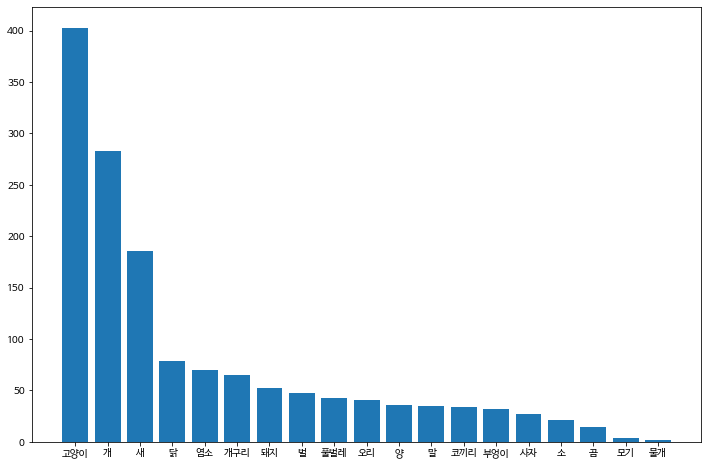

In [12]:
count_df = o_df.groupby('cate2').count().sort_values(by='name', ascending=False)
plt.figure(figsize=(12,8))
plt.bar(count_df.index, height=count_df['name'])

In [13]:
target_animals = ['고양이', '개', '새'] 
print(target_animals)
result_df = pd.DataFrame()
for a in target_animals:
    temp = o_df[o_df['cate2']== a].copy()
    result_df = pd.concat([result_df, temp])
result_df.reset_index(inplace=True, drop=True)
result_df

['고양이', '개', '새']


,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,2.612002e+05,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
1,cat_141,../../sounds/animal/고양이 소리/cat_141.wav,0.941723,0.409352,0.080211,0.165388,0.006663,2596.732198,5.135426e+04,1524.065073,...,11.936614,40.342899,-8.426805,32.566399,6.773017,36.244740,-3.884769,35.042721,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,1.751842e+05,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,5.188685e+05,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,4.352366e+05,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,crow008,../../sounds/animal/까마귀 소리/crow008.wav,5.000000,0.244974,0.105436,0.076835,0.009357,835.668498,9.979193e+05,785.605734,...,0.373137,13.366604,2.663044,16.687016,-0.512127,10.110376,-0.017016,19.100676,animal,새
868,5-243459-A-14,../../sounds/animal/새 소리/5-243459-A-14.wav,5.000000,0.266685,0.101788,0.036174,0.000845,3942.380489,4.653861e+05,1305.888959,...,5.196290,53.975945,4.467446,74.809502,-1.225562,131.637283,5.190821,58.226742,animal,새
869,bird006,../../sounds/animal/새 소리/bird006.wav,4.031837,0.169760,0.083790,0.024171,0.001215,1499.354852,2.316976e+06,679.320773,...,7.812654,87.415443,-4.891000,40.535492,3.942349,39.711033,-1.278223,24.045929,animal,새
870,bird007,../../sounds/animal/새 소리/bird007.wav,6.827937,0.374876,0.134908,0.087274,0.004589,1637.972320,2.807902e+05,1204.203528,...,8.759885,62.074379,-2.529569,88.179787,9.685721,74.181938,6.483904,83.937576,animal,새


In [14]:
result_df['duration'].describe()

count    872.000000
mean       7.571384
std        6.449574
min        0.570295
25%        3.398980
50%        5.000000
75%       11.700000
max       84.177007
Name: duration, dtype: float64

In [19]:
result_df[result_df['duration']<20].groupby('cate2').count().sort_values(by='name', ascending=False)

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
고양이,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
개,281,281,281,281,281,281,281,281,281,281,...,281,281,281,281,281,281,281,281,281,281
새,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162


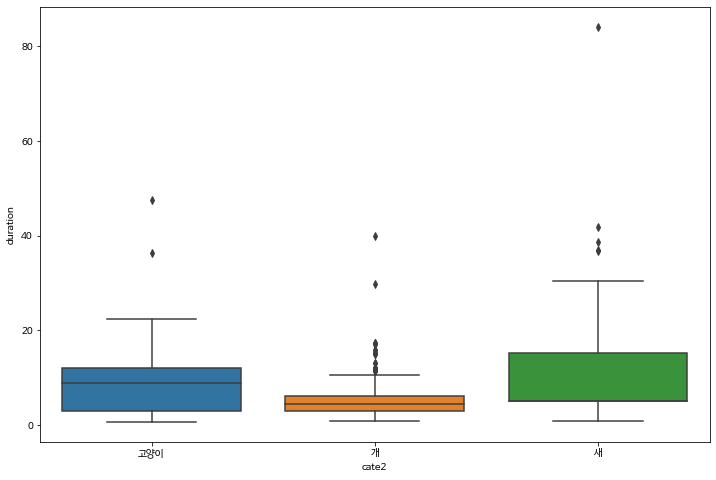

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df, x='cate2', y='duration');

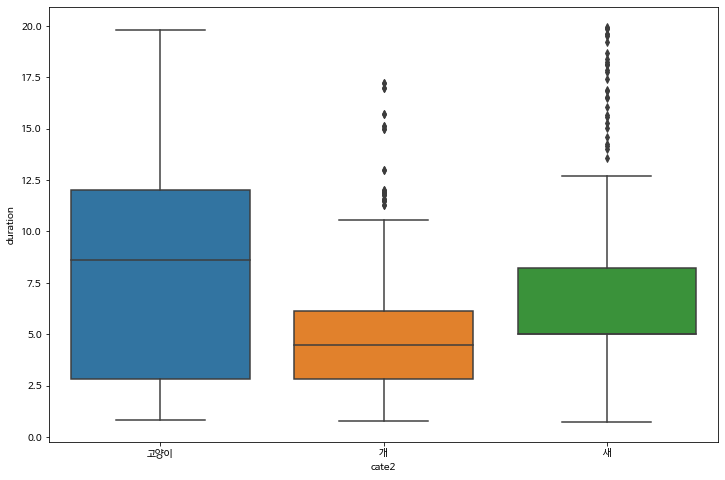

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df[result_df['duration']<20][result_df['duration']>0.7], x='cate2', y='duration');

In [22]:
result_df.groupby('cate2').count()

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
개,283,283,283,283,283,283,283,283,283,283,...,283,283,283,283,283,283,283,283,283,283
고양이,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
새,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186


In [23]:
long_out = result_df[result_df['duration']>20].index.tolist()
short_out = result_df[result_df['duration']<0.7].index.tolist()
print("너무 긴 outlier 제외: ", len(long_out))
print("너무 짧은 outlier 제외: ", len(short_out))

너무 긴 outlier 제외:  31
너무 짧은 outlier 제외:  2


In [24]:
final_df = result_df.drop(long_out+short_out, axis=0)
final_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,2.612002e+05,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
1,cat_141,../../sounds/animal/고양이 소리/cat_141.wav,0.941723,0.409352,0.080211,0.165388,0.006663,2596.732198,5.135426e+04,1524.065073,...,11.936614,40.342899,-8.426805,32.566399,6.773017,36.244740,-3.884769,35.042721,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,1.751842e+05,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,5.188685e+05,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,4.352366e+05,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,crow008,../../sounds/animal/까마귀 소리/crow008.wav,5.000000,0.244974,0.105436,0.076835,0.009357,835.668498,9.979193e+05,785.605734,...,0.373137,13.366604,2.663044,16.687016,-0.512127,10.110376,-0.017016,19.100676,animal,새
868,5-243459-A-14,../../sounds/animal/새 소리/5-243459-A-14.wav,5.000000,0.266685,0.101788,0.036174,0.000845,3942.380489,4.653861e+05,1305.888959,...,5.196290,53.975945,4.467446,74.809502,-1.225562,131.637283,5.190821,58.226742,animal,새
869,bird006,../../sounds/animal/새 소리/bird006.wav,4.031837,0.169760,0.083790,0.024171,0.001215,1499.354852,2.316976e+06,679.320773,...,7.812654,87.415443,-4.891000,40.535492,3.942349,39.711033,-1.278223,24.045929,animal,새
870,bird007,../../sounds/animal/새 소리/bird007.wav,6.827937,0.374876,0.134908,0.087274,0.004589,1637.972320,2.807902e+05,1204.203528,...,8.759885,62.074379,-2.529569,88.179787,9.685721,74.181938,6.483904,83.937576,animal,새


cate2
개      281
고양이    396
새      162
Name: name, dtype: int64


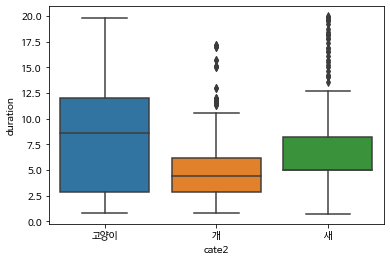

In [25]:
print(final_df.groupby('cate2').count()['name'])
sns.boxplot(data=final_df, x='cate2', y='duration');

---
# 분류

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import pickle
import joblib
import seaborn as sns

In [27]:
def play_song(path):
    (file_dir, file_id) = os.path.split(path)
    print(file_id[:-4])
    print(IPython.display.display(IPython.display.Audio(path)))
def play_song_ls(cm_lr_df):
    for idx, path in enumerate(cm_lr_df['path']):
        print(cm_lr_df['pred'].iloc[idx])
        play_song(path)

In [28]:
def make_train_test(df):
    df = df.sample(frac=1)
    X = df.set_index('path').drop(['name','cate1','cate2','duration'], axis=1)
    y = df.set_index('path')[['cate2']].copy()
    print(f"X 개수:{len(X)}, y 개수:{len(y)}")
    print(df.groupby('cate2').count().sort_values('name')[['name']])
    return X, y

In [29]:
def model_fit_kfold(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cf = confusion_matrix(y_test, y_pred)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    print("accuracy:", round(accuracy_score(y_test, y_pred),6))
    print("recall:", round(recall_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
    print("f1 score:", round(f1_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
#     print("Cross Validation Score:", cross_val_score(model, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=kfold))
    ax = sns.heatmap(cf, annot=True, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), fmt="d", cmap="Blues")
    plt.title(str(model).split('(')[0])
    plt.show()
    return model, y_pred

In [30]:
def check_false_pred(y_pred):
    cm_lr_df = pd.DataFrame()
    cm_lr_df['answer'] = y_test['cate1'].tolist()
    cm_lr_df['pred'] = y_pred
    cm_lr_df['result'] = cm_lr_df['answer'] == cm_lr_df['pred']
    cm_lr_df['path'] = X_test.index
    cm_lr_df['cate2'] = [result_df[result_df['path']== p]['cate2'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['noise'] = [result_df[result_df['path']== p]['noise'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['name'] = [f"{p.split('/')[-2]}__{p.split('/')[-1][:-4]}" for p in cm_lr_df['path']]
#     [l.split('/')[-1]for l in cm_lr_df['path']]
    cm_lr_df = cm_lr_df[cm_lr_df['result']==False].sort_values(['answer', 'cate2'])
    return cm_lr_df

---
# Total songs

### Test dataset 만들기

In [31]:
count_df = final_df.groupby('cate2').count().sort_values(by='name', ascending=False)['name']
count_df

cate2
고양이    396
개      281
새      162
Name: name, dtype: int64

<BarContainer object of 3 artists>

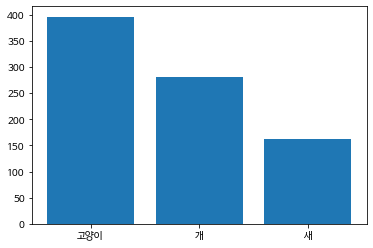

In [32]:
plt.bar(count_df.index, height=count_df)

In [34]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = final_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=150, random_state=13)
test_dog = test_df[test_df['cate2']=='개'].sample(n=100, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=62, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=28, random_state=13)
# test_goat = test_df[test_df['cate2']=='염소'].sample(n=18, random_state=13)
# test_frog = test_df[test_df['cate2']=='개구리'].sample(n=15, random_state=13)
# # test_pig = test_df[test_df['cate2']=='돼지'].sample(n=15, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,62
개,100
고양이,150


In [35]:
X_test, y_test = make_train_test(test_df)

X 개수:312, y 개수:312
       name
cate2      
새        62
개       100
고양이     150


In [36]:
train_df = result_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,124
개,183
고양이,253


X 개수:560, y 개수:560
       name
cate2      
새       124
개       183
고양이     253
---------DecisionTreeClassifier---------------
accuracy: 0.855769
recall: 0.856237
f1 score: 0.848125


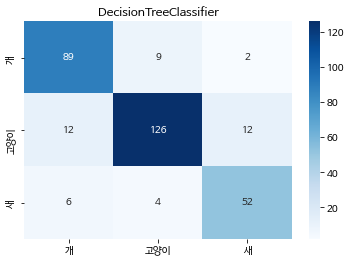

---------XGBClassifier---------------
accuracy: 0.923077
recall: 0.904194
f1 score: 0.911348


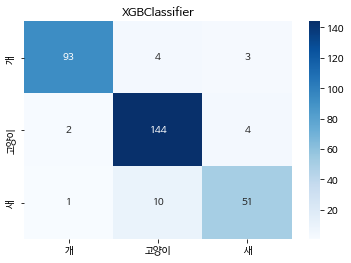

---------RandomForestClassifier---------------
accuracy: 0.891026
recall: 0.879749
f1 score: 0.884318


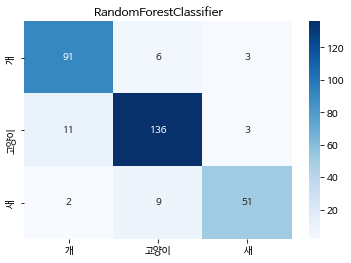

In [37]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.891026
recall: 0.879749
f1 score: 0.884318


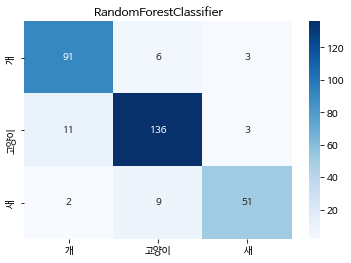

---------XGBClassifier---------------
accuracy: 0.923077
recall: 0.904194
f1 score: 0.911348


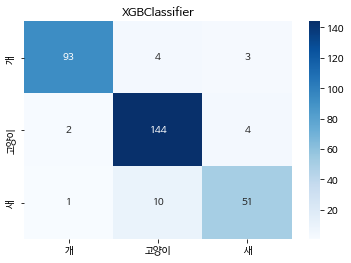

['models/XGB_animal3_1.pkl']

In [38]:
# print("---------DecisionTreeClassifier---------------")
# dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
# # 모델 저장
# joblib.dump(xgb_model, 'models/DTC_animal4_85.pkl')
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_1.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal3_1.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [40]:
X_test, y_test = make_train_test(test_df)
train_df = result_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=13).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:312, y 개수:312
       name
cate2      
새        62
개       100
고양이     150
X 개수:560, y 개수:560
       name
cate2      
새       124
개       183
고양이     253


,index
cate2,
개,255
고양이,253
새,265


---------DecisionTreeClassifier---------------
accuracy: 0.846154
recall: 0.843082
f1 score: 0.834919


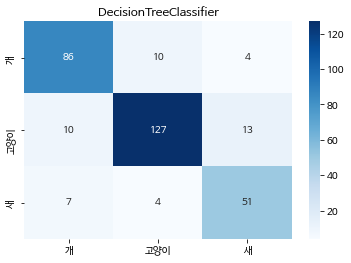

---------XGBClassifier---------------
accuracy: 0.910256
recall: 0.900502
f1 score: 0.900009


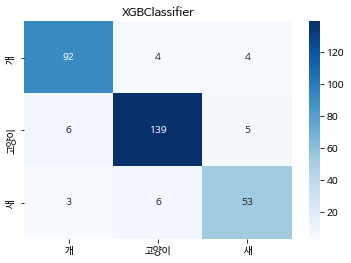

---------RandomForestClassifier---------------
accuracy: 0.916667
recall: 0.910143
f1 score: 0.907263


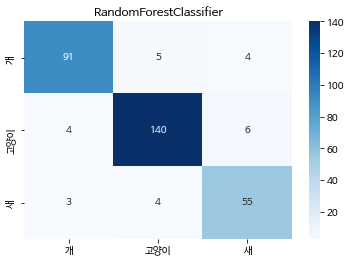

In [41]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.926282
recall: 0.91681
f1 score: 0.917489


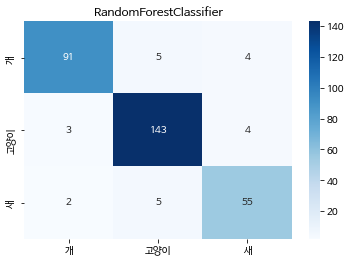

---------XGBClassifier---------------
accuracy: 0.910256
recall: 0.900502
f1 score: 0.900009


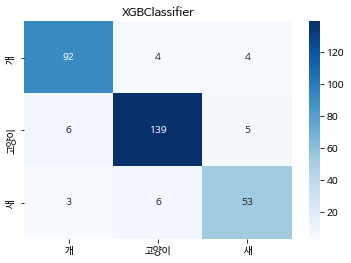

['models/XGB_animal3_1_oversampling.pkl']

In [52]:
# print("---------DecisionTreeClassifier---------------")
# dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
# # 모델 저장
# joblib.dump(xgb_model, 'models/DTC_animal4_1.pkl')

print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=50, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_1_oversampling.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal3_1_oversampling.pkl')

---
## 모델 저장하기
- short song
- long song

In [188]:
list(set(glob.glob(f'models/RF_animal6*')))

['models/RF_animal6_under3s_oversampling_83.pkl',
 'models/RF_animal6_over3s_oversampling_75.pkl',
 'models/RF_animal6_80.pkl',
 'models/RF_animal6_under3s_69.pkl']